In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr, pearsonr, ranksums, linregress
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
import itertools
import statannot
from statsmodels.stats.multitest import fdrcorrection

from deeplift.visualization import viz_sequence


matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'


HEPG2_COL = 'log2FoldChange_HepG2'
K562_COL = 'log2FoldChange_K562'
H2K_COL = 'log2FoldChange_H2K'

HEPG2_SE_COL = 'lfcSE_HepG2'
K562_SE_COL = 'lfcSE_K562'
H2K_SE_COL = 'lfcSE_H2K'

figure_dir = 'figures'

TITLE_FSIZE = 12
AXIS_FSIZE = 12
TEXT_FSIZE = 10

def seq_to_one_hot(seq,order_dict = {'A':0, 'T':3, 'C':1, 'G':2}):
    x = np.zeros((len(seq), 4))
    for (i, bp) in enumerate(seq):
        x[i, order_dict[bp]] = 1
    return x

greysBig = matplotlib.cm.get_cmap('Greys', 512)
greys_trunc_cm = matplotlib.colors.ListedColormap(greysBig(np.linspace(0.6, 1, 256)))

import scipy
def plot_scatter_shaded(x, y, ax, xlim=None, ylim=None, linreg=False, cmap=greys_trunc_cm, label=None,alpha=1,s=20):
    xy = np.vstack([x, y])
    z = scipy.stats.gaussian_kde(xy)(xy)
    ax.scatter(
        x,
        y,
        alpha=alpha,
        s = s,
        c=z,
        cmap=cmap,
        rasterized=True,
        label=label,
        zorder=20
    )

    if linreg:
        lrres = scipy.stats.linregress(
            x,
            y,
        )
        ax.axline((0, lrres.intercept), slope=lrres.slope, color='dodgerblue', linewidth=2)
        if xlim is None:
            xlim = ax.get_xlim()
        else:
            ax.set_xlim(xlim)
        if ylim is None:
            ylim = ax.get_ylim()
        else:
            ax.set_ylim(ylim)
        ax.annotate(
            f'$r^2$ = {lrres.rvalue**2:.3f}',
            xy=(xlim[0], ylim[1]),
            xytext=(4,-4), textcoords='offset points',
            va='top',
        )

        return lrres
    

# import logging from matplotlib
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

C:\Users\Chris\AppData\Local\Temp\ipykernel_6712\1715253149.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\Chris\AppData\Local\Temp\ipykernel_6712\1715253149.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  greysBig = matplotlib.cm.get_cmap('Greys', 512)


In [2]:
### Load D1, D2, and D3 data ###

d2_deseq_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/d2_deseq_data/chris_log2fc_df_clean2.csv')
# load in the dhs data
dhs_deseq_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis//fimo_motif_scanning/saved_processed_motif_files/dw_deseq_plus_cluster_cnts_df_qthresh05_v2.csv')

d1_final_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/fimo_motif_scanning/saved_processed_motif_files/d1_final_df_qthresh05_v2.csv')
d2_final_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/fimo_motif_scanning/saved_processed_motif_files/d2_final_df_qthresh05_v2.csv')
d3_final_df = pd.read_csv('../designed_seqs/d3_tot_final_df_qthresh0.05.csv')

d1_deseq_plus_cluster_cnts_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/fimo_motif_scanning/saved_processed_motif_files/d1_deseq_plus_cluster_cnts_df_qthresh05_v2_plus_cell_type.csv')
d2_deseq_plus_cluster_cnts_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/fimo_motif_scanning/saved_processed_motif_files/d2_deseq_plus_cluster_cnts_df_qthresh05_v2.csv')

# no longer need to process everytime loading this, I saved the processed + dna count thresholded version
# d3_deseq_df = pd.read_csv('illumina_processing/log2fc/log2fc_enhancer.csv')
# # rename 'Unnamed: 0' colum to 'sequence_name'
# d3_deseq_df.rename(columns={'Unnamed: 0': 'sequence_name'}, inplace=True)
# cols_to_merge = ['log2FoldChange_HepG2_DNA',
#                  'log2FoldChange_K562_DNA']

# d3_deseq_df['sequence_name'] = d3_deseq_df['sequence_name'].apply(lambda x: '_'.join(x.split('_')[1:]))

d3_seq_dir = '../designed_seqs'
# d3_seq_df = pd.read_csv(f'{d3_seq_dir}/d3_seq_df.csv')

# # add the cols_to_merge to the d3_seq_df, via sequence_name
# d3_seq_df = d3_seq_df.merge(d3_deseq_df[['sequence_name'] + cols_to_merge], on='sequence_name')
# d3_seq_df['log2FoldChange_H2K'] = d3_seq_df['log2FoldChange_HepG2_DNA'] - d3_seq_df['log2FoldChange_K562_DNA']
d3_seq_df = pd.read_csv(f'{d3_seq_dir}/d3_seq_df_thresh.csv')

# merge in the lfcSE columns
d3_deseq_df = pd.read_csv('illumina_processing/log2fc/log2fc_enhancer.csv')
# rename first column to sequence_name
d3_deseq_df.rename(columns={'Unnamed: 0':'sequence_name'},inplace=True)
# remove the 'design_' prefix from the sequence_name column
d3_deseq_df['sequence_name'] = d3_deseq_df['sequence_name'].apply(lambda x: x[7:])

# merge in lfcSE_HepG2_DNA and lfcSE_K562_DNA columns from d2_deseq_plus_cluster_cnts_df into top_enhancer_df by sequence_name
d3_seq_df = d3_seq_df.merge(d3_deseq_df[['sequence_name','lfcSE_HepG2_DNA','lfcSE_K562_DNA']],on='sequence_name',how='left')


d3_deseq_df_plus_cluster_cnts = pd.read_csv('../designed_seqs/d3_seq_df_plus_cluster_counts.csv')
cluster_cols = [col for col in d3_deseq_df_plus_cluster_cnts.columns if 'cluster' in col]
cluster_cols = ['n_motifs'] + cluster_cols

# merge cluster cols from d3_deseq_df_plus_cluster_cnts onto d3_seq_df, on sequence_name
d3_deseq_plus_cluster_cnts_df = d3_seq_df.merge(d3_deseq_df_plus_cluster_cnts[['sequence_name'] + cluster_cols], on='sequence_name')



In [3]:
D1_HEPG2_COL = 'log2FoldChange_HEPG2_DNA'
D1_K562_COL = 'log2FoldChange_K562_DNA'
D1_HEPG2_SE_COL = 'lfcSE_HEPG2_DNA'
D1_K562_SE_COL = 'lfcSE_K562_DNA'

D2_HEPG2_COL = 'log2FoldChange_HEPG2'
D2_K562_COL = 'log2FoldChange_K562'
D2_HEPG2_SE_COL = 'lfcSE_HEPG2'
D2_K562_SE_COL = 'lfcSE_K562'

D3_HEPG2_COL = 'log2FoldChange_HepG2_DNA'
D3_K562_COL = 'log2FoldChange_K562_DNA'
D3_HEPG2_SE_COL = 'lfcSE_HepG2_DNA'
D3_K562_SE_COL = 'lfcSE_K562_DNA'

# rename the columns to be consistent
d1_deseq_plus_cluster_cnts_df.rename(columns={D1_HEPG2_COL:HEPG2_COL,
                                                D1_K562_COL:K562_COL,
                                                D1_HEPG2_SE_COL:HEPG2_SE_COL,
                                                D1_K562_SE_COL:K562_SE_COL},inplace=True)

d2_deseq_df.rename(columns={D2_HEPG2_COL:HEPG2_COL,
                            D2_K562_COL:K562_COL,
                            D2_HEPG2_SE_COL:HEPG2_SE_COL,
                            D2_K562_SE_COL:K562_SE_COL},inplace=True)

d3_seq_df.rename(columns={D3_HEPG2_COL:HEPG2_COL,
                          D3_K562_COL:K562_COL,
                          D3_HEPG2_SE_COL:HEPG2_SE_COL,
                          D3_K562_SE_COL:K562_SE_COL},inplace=True)


dhs_deseq_df.rename(columns={D2_HEPG2_COL:HEPG2_COL,
                            D2_K562_COL:K562_COL,
                            D2_HEPG2_SE_COL:HEPG2_SE_COL,
                            D2_K562_SE_COL:K562_SE_COL},inplace=True)

In [4]:
# load in the comb_seq_df
# load in the combined data
comb_deseq_df = pd.read_csv('../../../aws/for_aws/sequencing_analysis/d2_deseq_data/combined_log2fc.csv')
# rename Unnamed: 0 to sequence
comb_deseq_df.rename(columns={'Unnamed: 0': 'enhancer'}, inplace=True)
# drop column X
comb_deseq_df.drop(columns=['X'], inplace=True)
comb_deseq_df.rename(columns={'log2FoldChange_HEPG2_DNA':f'{HEPG2_COL}_comb',
                              'log2FoldChange_K562_DNA':f'{K562_COL}_comb',
                              'lfcSE_HEPG2_DNA':f'{HEPG2_SE_COL}_comb',
                              'lfcSE_K562_DNA':f'{K562_SE_COL}_comb'},inplace=True)

In [5]:
# okay now I need to merge in the HEPG2, K562, HEPG2_SE_COL, and K562_SE_COL columns from comb_deseq_df into d2_deseq_df, also d2_deseq_plus_cluster_cnts_df
# replace the columns in d2_deseq_df with the columns from comb_deseq_df
d2_deseq_df = d2_deseq_df.merge(comb_deseq_df[['enhancer',f'{HEPG2_COL}_comb',f'{K562_COL}_comb',f'{HEPG2_SE_COL}_comb',f'{K562_SE_COL}_comb']],on='enhancer',how='left')
# replace values in HEPG2_COL with HEPG2_COL_comb, drop HEPG2_COL_comb
d2_deseq_df[HEPG2_COL] = d2_deseq_df[f'{HEPG2_COL}_comb']
d2_deseq_df[K562_COL] = d2_deseq_df[f'{K562_COL}_comb']
d2_deseq_df[HEPG2_SE_COL] = d2_deseq_df[f'{HEPG2_SE_COL}_comb']
d2_deseq_df[K562_SE_COL] = d2_deseq_df[f'{K562_SE_COL}_comb']

d2_deseq_df.drop(columns=[f'{HEPG2_COL}_comb',f'{K562_COL}_comb',f'{HEPG2_SE_COL}_comb',f'{K562_SE_COL}_comb'],inplace=True)

# recalculate H2K_COL and H2K_SE_COL
d2_deseq_df[H2K_COL] = d2_deseq_df[HEPG2_COL] - d2_deseq_df[K562_COL]
d2_deseq_df[H2K_SE_COL] = np.sqrt(d2_deseq_df[HEPG2_SE_COL]**2 + d2_deseq_df[K562_SE_COL]**2)

In [6]:
# do the same for the dhs_deseq_df
dhs_deseq_df = dhs_deseq_df.merge(comb_deseq_df[['enhancer',f'{HEPG2_COL}_comb',f'{K562_COL}_comb',f'{HEPG2_SE_COL}_comb',f'{K562_SE_COL}_comb']],on='enhancer',how='left')
dhs_deseq_df[HEPG2_COL] = dhs_deseq_df[f'{HEPG2_COL}_comb']
dhs_deseq_df[K562_COL] = dhs_deseq_df[f'{K562_COL}_comb']
dhs_deseq_df[HEPG2_SE_COL] = dhs_deseq_df[f'{HEPG2_SE_COL}_comb']
dhs_deseq_df[K562_SE_COL] = dhs_deseq_df[f'{K562_SE_COL}_comb']

dhs_deseq_df.drop(columns=[f'{HEPG2_COL}_comb',f'{K562_COL}_comb',f'{HEPG2_SE_COL}_comb',f'{K562_SE_COL}_comb'],inplace=True)

dhs_deseq_df[H2K_COL] = dhs_deseq_df[HEPG2_COL] - dhs_deseq_df[K562_COL]
dhs_deseq_df[H2K_SE_COL] = np.sqrt(dhs_deseq_df[HEPG2_SE_COL]**2 + dhs_deseq_df[K562_SE_COL]**2)

In [ ]:
# okay! the new deseq procs have been integrated, can now proceed with the rest of the batch correction and generate new files - need to do for dhs as well, new to this notebook

### R2 vs R1 linreg calculation (D3 to D2) ###

In [7]:
d2_ctrl_df = d2_ctrl_df = d2_deseq_df[d2_deseq_df['model']=='control_f'].copy()
d3_ctrl_df = d3_seq_df[d3_seq_df['model_type']=='d2_meas'].copy()
d3_ctrl_df['og_seq_idx'] = d3_ctrl_df['sequence_name'].apply(lambda x: int(x.split('_')[-1]))
d3_ctrl_inds = d3_ctrl_df['og_seq_idx'].values

d2_ctrl_df[H2K_SE_COL] = np.sqrt(d2_ctrl_df[HEPG2_SE_COL]**2 + d2_ctrl_df[K562_SE_COL]**2)
d3_ctrl_df[H2K_SE_COL] = np.sqrt(d3_ctrl_df[HEPG2_SE_COL]**2 + d3_ctrl_df[K562_SE_COL]**2)

ctrl_df = pd.DataFrame(zip(d2_ctrl_df[HEPG2_COL],d2_ctrl_df[HEPG2_SE_COL],d3_ctrl_df[HEPG2_COL],d3_ctrl_df[HEPG2_SE_COL],
                           d2_ctrl_df[K562_COL],d2_ctrl_df[K562_SE_COL],d3_ctrl_df[K562_COL],d3_ctrl_df[K562_SE_COL],
                           d2_ctrl_df[H2K_COL],d2_ctrl_df[H2K_SE_COL],d3_ctrl_df[H2K_COL],d3_ctrl_df[H2K_SE_COL]))

In [34]:
d2_ctrl_df = d2_ctrl_df = d2_deseq_df[d2_deseq_df['model']=='control_f'].copy()
d3_ctrl_df = d3_seq_df[d3_seq_df['model_type']=='d2_meas'].copy()
d3_ctrl_df['og_seq_idx'] = d3_ctrl_df['sequence_name'].apply(lambda x: int(x.split('_')[-1]))
d3_ctrl_inds = d3_ctrl_df['og_seq_idx'].values

d2_ctrl_df = d2_deseq_df.iloc[d3_ctrl_inds].copy()
d2_ctrl_df[H2K_SE_COL] = np.sqrt(d2_ctrl_df[HEPG2_SE_COL]**2 + d2_ctrl_df[K562_SE_COL]**2)
d3_ctrl_df[H2K_SE_COL] = np.sqrt(d3_ctrl_df[HEPG2_SE_COL]**2 + d3_ctrl_df[K562_SE_COL]**2)

ctrl_df = pd.DataFrame(zip(d2_ctrl_df[HEPG2_COL],d2_ctrl_df[HEPG2_SE_COL],d3_ctrl_df[HEPG2_COL],d3_ctrl_df[HEPG2_SE_COL],
                           d2_ctrl_df[K562_COL],d2_ctrl_df[K562_SE_COL],d3_ctrl_df[K562_COL],d3_ctrl_df[K562_SE_COL],
                           d2_ctrl_df[H2K_COL],d2_ctrl_df[H2K_SE_COL],d3_ctrl_df[H2K_COL],d3_ctrl_df[H2K_SE_COL]))

ctrl_df.columns = ['D2 HEPG2','D2 HEPG2 SE','D3 HEPG2','D3 HEPG2 SE',
                   'D2 K562','D2 K562 SE','D3 K562','D3 K562 SE',
                   'D2 H2K','D2 H2K SE','D3 H2K','D3 H2K SE']

## HEPG2 ##

weights = 1 / (ctrl_df['D2 HEPG2 SE']**2 + ctrl_df['D3 HEPG2 SE']**2)
weights /= weights.sum()

# weighted linear regression using polyfit
wlr = np.polyfit(ctrl_df['D2 HEPG2'],ctrl_df['D3 HEPG2'],1,w=weights)

# regress D2 HEPG2 on D3 HEPG2
m_hepg2,b_hepg2 = wlr.tolist()

## K562 ##

# # calculate weighted linear regression between D3 HEPG2 and D2 HEPG2

weights = 1 / (ctrl_df['D2 K562 SE']**2 + ctrl_df['D3 K562 SE']**2)
weights /= weights.sum()

# weighted linear regression using polyfit
wlr = np.polyfit(ctrl_df['D2 K562'],ctrl_df['D3 K562'],1,w=weights)
m_k562,b_k562 = wlr.tolist()

## H2K ##
weights = 1 / (ctrl_df['D2 H2K SE']**2 + ctrl_df['D3 H2K SE']**2)
weights /= weights.sum()

# weighted linear regression using polyfit
wlr = np.polyfit(ctrl_df['D2 H2K'],ctrl_df['D3 H2K'],1,w=weights)
m_h2k,b_h2k = wlr.tolist()

# print out the slopes and intercepts
print(f'm: {m_hepg2:.3f}, b: {b_hepg2:.3f}')
print(f'm: {m_k562:.3f}, b: {b_k562:.3f}')
print(f'm: {m_h2k:.3f}, b: {b_h2k:.3f}')


# save m_hepg2, b_hepg2, m_k562, b_k562 to npy file
np.save('batch_correction_weights/comb_dhs/d2_to_d3_linregs_weighted_pf.npy',np.array([m_hepg2, b_hepg2, m_k562, b_k562,m_h2k,b_h2k]))

m: 0.898, b: -0.692
m: 0.883, b: -1.053
m: 0.888, b: 0.351


In [ ]:
m: 0.888, b: -0.447
m: 0.873, b: -0.555
m: 0.881, b: 0.091

In [96]:
# # alternate version - use statsmodes with intercept
# import statsmodels.api as sm

# ## HEPG2 ##

# # # calculate weighted linear regression between D3 HEPG2 and D2 HEPG2

# w = 1 / (ctrl_df['D2 HEPG2 SE']**2 + ctrl_df['D3 HEPG2 SE']**2)
# x = ctrl_df['D2 HEPG2']
# y = ctrl_df['D3 HEPG2']
# # Add a constant term to the independent variable matrix
# X = sm.add_constant(x)
# # Fit the weighted linear regression model
# model = sm.WLS(y, X, weights=w)  # Note: You can use weights directly or specify them in the `WLS` function
# results = model.fit()
# # regress D2 HEPG2 on D1 HEPG2
# m_hepg2,b_hepg2 = results.params.tolist()[::-1]
# print(f'm: {m_hepg2:.3f}, b: {b_hepg2:.3f}')

# ## K562 ##

# w = 1 / (ctrl_df['D2 K562 SE']**2 + ctrl_df['D3 K562 SE']**2)
# x = ctrl_df['D2 K562']
# y = ctrl_df['D3 K562']
# # Add a constant term to the independent variable matrix
# X = sm.add_constant(x)
# # Fit the weighted linear regression model
# model = sm.WLS(y, X, weights=w)  # Note: You can use weights directly or specify them in the `WLS` function
# results = model.fit()
# # regress D2 K562 on D1 K562
# m_k562,b_k562 = results.params.tolist()[::-1]
# print(f'm: {m_k562:.3f}, b: {b_k562:.3f}')

# ## H2K ##

# w = 1 / (ctrl_df['D2 H2K SE']**2 + ctrl_df['D3 H2K SE']**2)
# x = ctrl_df['D2 H2K']
# y = ctrl_df['D3 H2K']
# # Add a constant term to the independent variable matrix
# X = sm.add_constant(x)
# # Fit the weighted linear regression model
# model = sm.WLS(y, X, weights=w)  # Note: You can use weights directly or specify them in the `WLS` function
# results = model.fit()
# # regress D2 H2K on D1 H2K
# m_h2k,b_h2k = results.params.tolist()[::-1]
# print(f'm: {m_h2k:.3f}, b: {b_h2k:.3f}')

# # save m_hepg2, b_hepg2, m_k562, b_k562 to npy file
# np.save('d2_to_d3_linregs_weighted_sm.npy',np.array([m_hepg2, b_hepg2, m_k562, b_k562,m_h2k,b_h2k]))

m: 0.871, b: -0.378
m: 0.853, b: -0.475
m: 0.856, b: 0.092


### R1 vs R0 linreg calculation ###

In [35]:
# # alternate version - use statsmodes with intercept
# import statsmodels.api as sm

d2_ctrl_df = d2_ctrl_df = d2_deseq_df[d2_deseq_df['model']=='control_f'].copy()
d1_ctrl_df = d1_deseq_plus_cluster_cnts_df[d1_deseq_plus_cluster_cnts_df['seq'].isin(d2_ctrl_df['enhancer'])].copy()

d2_ctrl_df[H2K_SE_COL] = np.sqrt(d2_ctrl_df[HEPG2_SE_COL]**2 + d2_ctrl_df[K562_SE_COL]**2)
d1_ctrl_df[H2K_SE_COL] = np.sqrt(d1_ctrl_df[HEPG2_SE_COL]**2 + d1_ctrl_df[K562_SE_COL]**2)

ctrl_df = pd.DataFrame(zip(d2_ctrl_df[HEPG2_COL],d2_ctrl_df[HEPG2_SE_COL],d1_ctrl_df[HEPG2_COL],d1_ctrl_df[HEPG2_SE_COL],
                           d2_ctrl_df[K562_COL],d2_ctrl_df[K562_SE_COL],d1_ctrl_df[K562_COL],d1_ctrl_df[K562_SE_COL],
                           d2_ctrl_df[H2K_COL],d2_ctrl_df[H2K_SE_COL],d1_ctrl_df[H2K_COL],d1_ctrl_df[H2K_SE_COL]))
ctrl_df.columns = ['D2 HEPG2','D2 HEPG2 SE','D1 HEPG2','D1 HEPG2 SE',
                   'D2 K562','D2 K562 SE','D1 K562','D1 K562 SE',
                   'D2 H2K','D2 H2K SE','D1 H2K','D1 H2K SE']

## HEPG2 ##

weights = 1 / (ctrl_df['D2 HEPG2 SE']**2 + ctrl_df['D1 HEPG2 SE']**2)
weights /= weights.sum()

# weighted linear regression using polyfit
wlr = np.polyfit(ctrl_df['D1 HEPG2'],ctrl_df['D2 HEPG2'],1,w=weights)

# regress D2 HEPG2 on D1 HEPG2
m_hepg2,b_hepg2 = wlr.tolist()

## K562 ##

# # calculate weighted linear regression between D3 HEPG2 and D2 HEPG2

weights = 1 / (ctrl_df['D2 K562 SE']**2 + ctrl_df['D1 K562 SE']**2)
weights /= weights.sum()

# weighted linear regression using polyfit
wlr = np.polyfit(ctrl_df['D1 K562'],ctrl_df['D2 K562'],1,w=weights)
m_k562,b_k562 = wlr.tolist()

## H2K ##
weights = 1 / (ctrl_df['D2 H2K SE']**2 + ctrl_df['D1 H2K SE']**2)
weights /= weights.sum()

# weighted linear regression using polyfit
wlr = np.polyfit(ctrl_df['D1 H2K'],ctrl_df['D2 H2K'],1,w=weights)
m_h2k,b_h2k = wlr.tolist()

# print out the slopes and intercepts
print(f'm: {m_hepg2:.3f}, b: {b_hepg2:.3f}')
print(f'm: {m_k562:.3f}, b: {b_k562:.3f}')
print(f'm: {m_h2k:.3f}, b: {b_h2k:.3f}')


# save m_hepg2, b_hepg2, m_k562, b_k562 to npy file
np.save('batch_correction_weights/comb_dhs/d1_to_d2_linregs_weighted_pf.npy',np.array([m_hepg2, b_hepg2, m_k562, b_k562,m_h2k,b_h2k]))

m: 0.626, b: -1.524
m: 0.614, b: -1.289
m: 0.518, b: -0.421


In [89]:
# # alternate version - use statsmodes with intercept
# import statsmodels.api as sm

# d2_ctrl_df = d2_ctrl_df = d2_deseq_df[d2_deseq_df['model']=='control_f'].copy()
# d1_ctrl_df = d1_deseq_plus_cluster_cnts_df[d1_deseq_plus_cluster_cnts_df['seq'].isin(d2_ctrl_df['enhancer'])].copy()

# d2_ctrl_df[H2K_SE_COL] = np.sqrt(d2_ctrl_df[HEPG2_SE_COL]**2 + d2_ctrl_df[K562_SE_COL]**2)
# d1_ctrl_df[H2K_SE_COL] = np.sqrt(d1_ctrl_df[HEPG2_SE_COL]**2 + d1_ctrl_df[K562_SE_COL]**2)

# ctrl_df = pd.DataFrame(zip(d2_ctrl_df[HEPG2_COL],d2_ctrl_df[HEPG2_SE_COL],d1_ctrl_df[HEPG2_COL],d1_ctrl_df[HEPG2_SE_COL],
#                            d2_ctrl_df[K562_COL],d2_ctrl_df[K562_SE_COL],d1_ctrl_df[K562_COL],d1_ctrl_df[K562_SE_COL],
#                            d2_ctrl_df[H2K_COL],d2_ctrl_df[H2K_SE_COL],d1_ctrl_df[H2K_COL],d1_ctrl_df[H2K_SE_COL]))
# ctrl_df.columns = ['D2 HEPG2','D2 HEPG2 SE','D1 HEPG2','D1 HEPG2 SE',
#                    'D2 K562','D2 K562 SE','D1 K562','D1 K562 SE',
#                    'D2 H2K','D2 H2K SE','D1 H2K','D1 H2K SE']

# ## HEPG2 ##

# # # calculate weighted linear regression between D3 HEPG2 and D2 HEPG2

# w = 1 / (ctrl_df['D2 HEPG2 SE']**2 + ctrl_df['D1 HEPG2 SE']**2)
# x = ctrl_df['D1 HEPG2']
# y = ctrl_df['D2 HEPG2']
# # Add a constant term to the independent variable matrix
# X = sm.add_constant(x)
# # Fit the weighted linear regression model
# model = sm.WLS(y, X, weights=w)  # Note: You can use weights directly or specify them in the `WLS` function
# results = model.fit()
# # regress D2 HEPG2 on D1 HEPG2
# m_hepg2,b_hepg2 = results.params.tolist()[::-1]
# print(f'm: {m_hepg2:.3f}, b: {b_hepg2:.3f}')

# ## K562 ##

# w = 1 / (ctrl_df['D2 K562 SE']**2 + ctrl_df['D1 K562 SE']**2)
# x = ctrl_df['D1 K562']
# y = ctrl_df['D2 K562']
# # Add a constant term to the independent variable matrix
# X = sm.add_constant(x)
# # Fit the weighted linear regression model
# model = sm.WLS(y, X, weights=w)  # Note: You can use weights directly or specify them in the `WLS` function
# results = model.fit()
# # regress D2 K562 on D1 K562
# m_k562,b_k562 = results.params.tolist()[::-1]
# print(f'm: {m_k562:.3f}, b: {b_k562:.3f}')

# ## H2K ##

# w = 1 / (ctrl_df['D2 H2K SE']**2 + ctrl_df['D1 H2K SE']**2)
# x = ctrl_df['D1 H2K']
# y = ctrl_df['D2 H2K']
# # Add a constant term to the independent variable matrix
# X = sm.add_constant(x)
# # Fit the weighted linear regression model
# model = sm.WLS(y, X, weights=w)  # Note: You can use weights directly or specify them in the `WLS` function
# results = model.fit()
# # regress D2 H2K on D1 H2K
# m_h2k,b_h2k = results.params.tolist()[::-1]
# print(f'm: {m_h2k:.3f}, b: {b_h2k:.3f}')

# # save m_hepg2, b_hepg2, m_k562, b_k562 to npy file
# np.save('d1_to_d2_linregs_weighted_sm.npy',np.array([m_hepg2, b_hepg2, m_k562, b_k562,m_h2k,b_h2k]))

m: 0.600, b: -1.726
m: 0.585, b: -1.702
m: 0.500, b: -0.133


In [ ]:
# # unweighted

# m: 0.580, b: -1.700
# m: 0.546, b: -1.591
# m: 0.482, b: -0.107

# # polyfit - why is this different from statsmodels? but, this might be better: higher slopes >> lower intercepts?
# m: 0.620, b: -1.776
# m: 0.618, b: -1.852
# m: 0.516, b: -0.153

# #statsmodel
# m: 0.600, b: -1.726
# m: 0.585, b: -1.702
# m: 0.500, b: -0.133

In [3]:
d2_cols = ['enhancer','log2FoldChange_HEPG2','log2FoldChange_K562','log2FoldChange_H2K','cell_type']
d2_ctrl_df = d2_deseq_df[d2_deseq_df['model']=='control_f'][d2_cols].copy()
# reset index
d2_ctrl_df.reset_index(inplace=True,drop=True)
# rename cols to D2 HEPG2, D2 K562, D2 H2K
d2_ctrl_df.rename(columns={'log2FoldChange_HEPG2': 'D2 HEPG2',
                           'log2FoldChange_K562': 'D2 K562',
                           'log2FoldChange_H2K': 'D2 H2K'}, inplace=True)


d1_cols = ['log2FoldChange_HEPG2_DNA','log2FoldChange_K562_DNA','log2FoldChange_H2K']
# get rows of d1_deseq_plus_cluster_cnts_df where seq is in d2_ctrl_df['enhancer]
d1_ctrl_df = d1_deseq_plus_cluster_cnts_df[d1_deseq_plus_cluster_cnts_df['seq'].isin(d2_ctrl_df['enhancer'])][d1_cols].copy()
# reset index
d1_ctrl_df.reset_index(inplace=True,drop=True)
# rename cols to D1 HEPG2, D1 K562, D1 H2K
d1_ctrl_df.rename(columns={'log2FoldChange_HEPG2_DNA': 'D1 HEPG2',
                           'log2FoldChange_K562_DNA': 'D1 K562',
                           'log2FoldChange_H2K': 'D1 H2K'}, inplace=True)

# concatenate d1_ctrl_df and d2_ctrl_df axis=1
ctrl_df = pd.concat([d1_ctrl_df,d2_ctrl_df],axis=1)
# drop enhancer column
ctrl_df.drop(columns=['enhancer'],inplace=True)


# d2_ctrl_df['og_seq_idx'] = d2_ctrl_df['sequence_name'].apply(lambda x: int(x.split('_')[-1]))
# d3_ctrl_inds = d2_ctrl_df['og_seq_idx'].values

In [9]:
# regress D2 HEPG2 on D1 HEPG2
m_hepg2,b_hepg2 = np.polyfit(ctrl_df['D1 HEPG2'],ctrl_df['D2 HEPG2'],1)
# regress D2 K562 on D1 K562
m_k562,b_k562 = np.polyfit(ctrl_df['D1 K562'],ctrl_df['D2 K562'],1)
# regress D2 H2K on D1 H2K
m_h2k,b_h2k = np.polyfit(ctrl_df['D1 H2K'],ctrl_df['D2 H2K'],1)

# also get correlations for each of these
corr_hepg2,p_hepg2 = pearsonr(ctrl_df['D1 HEPG2'],ctrl_df['D2 HEPG2'])
corr_k562,p_k562 = pearsonr(ctrl_df['D1 K562'],ctrl_df['D2 K562'])
corr_h2k,p_h2k = pearsonr(ctrl_df['D1 H2K'],ctrl_df['D2 H2K'])

# print out the slopes and intercepts
print(f'm: {m_hepg2:.3f}, b: {b_hepg2:.3f}, pcc: {corr_hepg2:.3f}')
print(f'm: {m_k562:.3f}, b: {b_k562:.3f}, pcc: {corr_k562:.3f}')
print(f'm: {m_h2k:.3f}, b: {b_h2k:.3f}, pcc: {corr_h2k:.3f}')

m: 0.580, b: -1.700, pcc: 0.812
m: 0.546, b: -1.591, pcc: 0.782
m: 0.482, b: -0.107, pcc: 0.791


Text(0.5, 1.0, 'D1 vs D2 Control Sequences (n=100)')

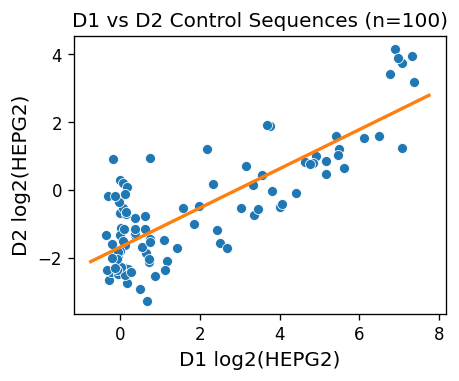

In [11]:
# scatterplot of D1 HEPG2 vs D2 HEPG2
plt.figure(figsize=(4,3))
sns.scatterplot(x='D1 HEPG2',y='D2 HEPG2',data=ctrl_df)
plt.xlabel('D1 log2(HEPG2)',fontsize=AXIS_FSIZE)
plt.ylabel('D2 log2(HEPG2)',fontsize=AXIS_FSIZE)

# plot line of best fit with m_hepg2,b_hepg2
xlim = plt.xlim()
x = np.array([xlim[0],xlim[1]])
y = m_hepg2*x + b_hepg2
plt.plot(x,y,color='tab:orange',linewidth=2)
# add title
plt.title(f'D1 vs D2 Control Sequences (n={ctrl_df.shape[0]})',fontsize=TITLE_FSIZE)


Text(0.5, 1.0, 'D1 vs D2 Control Sequences (n=100)')

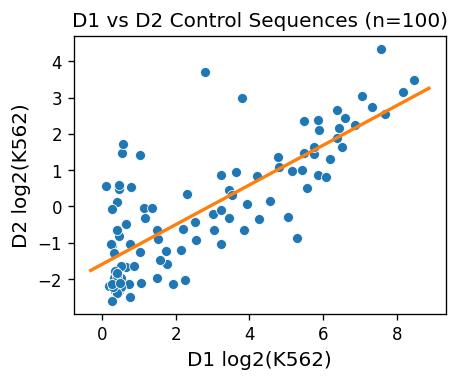

In [12]:
# scatterplot of D1 K562 vs D2 K562
plt.figure(figsize=(4,3))
sns.scatterplot(x='D1 K562',y='D2 K562',data=ctrl_df)
plt.xlabel('D1 log2(K562)',fontsize=AXIS_FSIZE)
plt.ylabel('D2 log2(K562)',fontsize=AXIS_FSIZE)
# plot line of best fit with m_k562,b_k562
xlim = plt.xlim()
x = np.array([xlim[0],xlim[1]])
y = m_k562*x + b_k562
plt.plot(x,y,color='tab:orange',linewidth=2)
# add title
plt.title(f'D1 vs D2 Control Sequences (n={ctrl_df.shape[0]})',fontsize=TITLE_FSIZE)


In [7]:
# calculate linreg D1 HEPG2
ctrl_df['D1 HEPG2 linreg'] = m_hepg2 * ctrl_df['D1 HEPG2'] + b_hepg2
# calculate linreg D1 K562
ctrl_df['D1 K562 linreg'] = m_k562 * ctrl_df['D1 K562'] + b_k562
# calculate linreg D1 H2K
ctrl_df['D1 H2K linreg'] = m_h2k * ctrl_df['D1 H2K'] + b_h2k
# calculate linreg D1 H2K sep
ctrl_df['D1 H2K linreg sep'] = ctrl_df['D1 HEPG2 linreg'] - ctrl_df['D1 K562 linreg']

m: 1.1676399172798682, b: 0.09544508577448597


Text(0.5, 1.0, 'D2 vs D3 Control Sequences (n=100)')

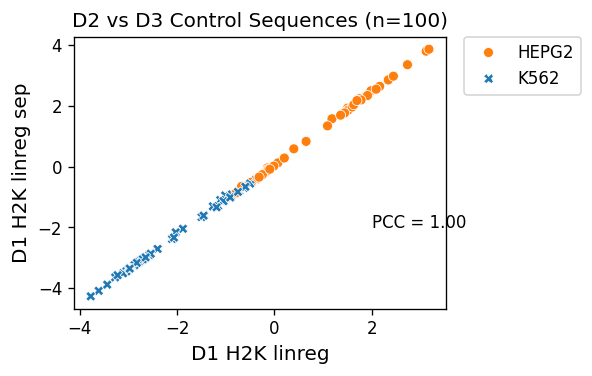

In [8]:
col1 = 'D1 H2K linreg'
col2 = 'D1 H2K linreg sep'
corr,p = pearsonr(ctrl_df[col1],ctrl_df[col2])
# calculate slope and intercept of linear regression
m_k562,b_k562 = np.polyfit(ctrl_df[col1],ctrl_df[col2],1)
print(f'm: {m_k562}, b: {b_k562}')

# scatterplot of D2 vs D3 H2K for control sequences, colored by cell_type
plt.figure(figsize=(4,3))
sns.scatterplot(x=col1,y=col2,hue='cell_type',data=ctrl_df,palette=palette,style='cell_type')
plt.xlabel(f'{col1}',fontsize=AXIS_FSIZE)
plt.ylabel(f'{col2}',fontsize=AXIS_FSIZE)
# move legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# add correlation to plot
plt.text(2,-2,f'PCC = {corr:.2f}',fontsize=TEXT_FSIZE)
# add title
plt.title(f'D2 vs D3 Control Sequences (n={ctrl_df.shape[0]})',fontsize=TITLE_FSIZE)

In [137]:
ctrl_df[[col1,col2]]

,D1 H2K linreg,D1 H2K linreg sep
0,-0.200637,-0.213346
1,2.334215,2.841722
2,-2.877588,-3.259343
3,-0.982390,-1.019398
4,2.336902,2.847498
...,...,...
95,-2.063631,-2.334717
96,1.777097,2.188578
97,1.693359,2.168244
98,-0.341185,-0.377590


In [151]:
# save m_hepg2, b_hepg2, m_k562, b_k562 to npy file
np.save('d1_to_d2_linregs.npy',np.array([m_hepg2, b_hepg2, m_k562, b_k562]))

In [ ]:
# Okay! well, that's that I guess. what I need to do now is calculate the D1 -> D3 regression for the scatterplots in Fig 1.
# and then also calculate the D2 -> D3 regression for the Fig 1 scatterplot. I guess I can just move this over to the d3_figure_notebook now...though maybe I should start breaking up by figures, I don't know...
# Then I need to figure out what boxswarm comparisons to plot.